# 基于`LSTM模型`预测未来一个交易日`开盘价的涨跌`

## 1. 数据预处理
### 1.1 根据股票代码划分数据

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np

# 全局变量
cols = [0,1,2,3,4,6,7,9,10,12,13,14,16,17,18,20] # 选取属性
feanum= len(cols) - 3 # 特征数量
window=5 # 时间窗设置

/home/tianhao/env4tiho_py36/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tianhao/env4tiho_py36/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


* **训练集**

In [2]:
train_df = pd.read_csv("../data/trainData.csv", usecols=cols)
# train_df = pd.read_csv("../data/trainData.csv")
train_stocks_code = train_df["kdcode"].unique()
train_stocks_num = len(train_stocks_code)

"训练集股票数量：",train_stocks_num

('训练集股票数量：', 3727)

In [3]:
print(train_df.columns)
train_df

Index(['dt', 'kdcode', 'vwap', 'vwap_mean5', 'vwap_mean10', 'chg_mean3',
       'chg_mean5', 'open_mean3', 'open_mean5', 'CCI_1', 'CCI_3', 'CCI_5',
       'EVM_1', 'EVM_3', 'EVM_5', 'label'],
      dtype='object')


,dt,kdcode,vwap,vwap_mean5,vwap_mean10,chg_mean3,chg_mean5,open_mean3,open_mean5,CCI_1,CCI_3,CCI_5,EVM_1,EVM_3,EVM_5,label
0,2016-01-04,000001.SZ,0.004588,0.004771,0.004929,0.016312,0.016312,0.004158,0.004158,0.626134,0.354606,0.236960,0.000000,0.000000,0.000000,0.0
1,2016-01-05,000001.SZ,0.004460,0.004704,0.004860,0.019133,0.019133,0.004031,0.004031,0.626134,0.351945,0.235208,0.759156,0.000000,0.000000,1.0
2,2016-01-06,000001.SZ,0.004492,0.004693,0.004849,0.020236,0.020236,0.004007,0.004007,0.626134,0.355549,0.237580,0.759156,0.000000,0.000000,0.0
3,2016-01-07,000001.SZ,0.004365,0.004655,0.004809,0.020356,0.019345,0.003938,0.003993,0.626134,0.346662,0.230558,0.759153,0.686411,0.000000,0.0
4,2016-01-08,000001.SZ,0.004354,0.004629,0.004783,0.020673,0.020057,0.003931,0.003971,0.626134,0.350294,0.232116,0.759156,0.686411,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180235,2019-12-25,688399.SH,0.023073,0.024004,0.024275,0.021490,0.020265,0.000243,0.000244,0.622992,0.355925,0.236890,0.759156,0.686412,0.771513,1.0
3180236,2019-12-26,688399.SH,0.023324,0.024009,0.024414,0.021819,0.021620,0.000243,0.000243,0.623024,0.357571,0.239390,0.759156,0.686412,0.771513,1.0
3180237,2019-12-27,688399.SH,0.022889,0.023941,0.024554,0.020470,0.020870,0.000245,0.000244,0.622942,0.349210,0.233741,0.759156,0.686412,0.771513,0.0
3180238,2019-12-30,688399.SH,0.021950,0.023756,0.024559,0.020101,0.020704,0.000241,0.000242,0.622840,0.343091,0.227766,0.759156,0.686412,0.771513,1.0


In [4]:
# 根据股票代码划分数据
for i, stock_i in enumerate(tqdm(train_stocks_code)):
    stock_i_data = train_df[train_df['kdcode'].isin([stock_i])]
    exec("train_df%s = stock_i_data" % i)

100%|██████████| 3727/3727 [02:11<00:00, 28.30it/s]


* **测试集**

In [5]:
test_df = pd.read_csv("../data/testData.csv", usecols=cols)
# test_df = pd.read_csv("../data/testData.csv")
test_stocks_code = test_df["kdcode"].unique()
test_stocks_num = len(test_stocks_code)

"测试集股票数量：",test_stocks_num

('测试集股票数量：', 4022)

In [6]:
# 根据股票代码划分数据
for i, stock_i in enumerate(tqdm(test_stocks_code)):
    stock_i_data = test_df[test_df['kdcode'].isin([stock_i])]
    exec("test_df%s = stock_i_data" % i)

100%|██████████| 4022/4022 [01:08<00:00, 59.02it/s]


### 1.2. 将原始数据改造为LSTM网络的输入
分割出window个时间窗的数据为输入的`X`

紧接着的那条数据为标签`Y`

因此需要将每只股票的数据按照时间(日期)分割成`window + 1`长度的数据

* **训练集**

In [7]:
train_df

,dt,kdcode,vwap,vwap_mean5,vwap_mean10,chg_mean3,chg_mean5,open_mean3,open_mean5,CCI_1,CCI_3,CCI_5,EVM_1,EVM_3,EVM_5,label
0,2016-01-04,000001.SZ,0.004588,0.004771,0.004929,0.016312,0.016312,0.004158,0.004158,0.626134,0.354606,0.236960,0.000000,0.000000,0.000000,0.0
1,2016-01-05,000001.SZ,0.004460,0.004704,0.004860,0.019133,0.019133,0.004031,0.004031,0.626134,0.351945,0.235208,0.759156,0.000000,0.000000,1.0
2,2016-01-06,000001.SZ,0.004492,0.004693,0.004849,0.020236,0.020236,0.004007,0.004007,0.626134,0.355549,0.237580,0.759156,0.000000,0.000000,0.0
3,2016-01-07,000001.SZ,0.004365,0.004655,0.004809,0.020356,0.019345,0.003938,0.003993,0.626134,0.346662,0.230558,0.759153,0.686411,0.000000,0.0
4,2016-01-08,000001.SZ,0.004354,0.004629,0.004783,0.020673,0.020057,0.003931,0.003971,0.626134,0.350294,0.232116,0.759156,0.686411,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180235,2019-12-25,688399.SH,0.023073,0.024004,0.024275,0.021490,0.020265,0.000243,0.000244,0.622992,0.355925,0.236890,0.759156,0.686412,0.771513,1.0
3180236,2019-12-26,688399.SH,0.023324,0.024009,0.024414,0.021819,0.021620,0.000243,0.000243,0.623024,0.357571,0.239390,0.759156,0.686412,0.771513,1.0
3180237,2019-12-27,688399.SH,0.022889,0.023941,0.024554,0.020470,0.020870,0.000245,0.000244,0.622942,0.349210,0.233741,0.759156,0.686412,0.771513,0.0
3180238,2019-12-30,688399.SH,0.021950,0.023756,0.024559,0.020101,0.020704,0.000241,0.000242,0.622840,0.343091,0.227766,0.759156,0.686412,0.771513,1.0


In [8]:
# 分割数据
trainResult = []
for i in tqdm(range(train_stocks_num)): # 遍历训练集所有股票的DataFrame
    exec("trainData = train_df%s.values" % i)
    sequence_length = window + 1
    for index in range(len(trainData) - sequence_length + 1):
        trainResult.append(trainData[index: index + sequence_length])

trainResult = np.array(trainResult)
trainResult.shape

100%|██████████| 3727/3727 [00:03<00:00, 1163.07it/s]


(3161618, 6, 16)

In [9]:
# 保存分割后每条数据的日期
train_date = trainResult[:,-1,0]
len(train_date)

3161618

* **测试集**

In [10]:
testResult = []
for i in tqdm(range(test_stocks_num)): # 遍历训练集所有股票的DataFrame
    exec("testData = test_df%s.values" % i)
    sequence_length = window + 1
    for index in range(len(testData) - sequence_length + 1):
        testResult.append(testData[index: index + sequence_length])

testResult = np.array(testResult)
testResult.shape

100%|██████████| 4022/4022 [00:01<00:00, 2910.89it/s]


(1480414, 6, 16)

In [11]:
# 保存分割后每条数据的日期
test_date = testResult[:,-1,0]
len(test_date)

1480414

**分割出X**

In [12]:
X_train = trainResult[:, :-1, 2:-1]
X_test = testResult[:, :-1, 2:-1]
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
print("训练集X：" + str(X_train.shape))
print("测试集X：" + str(X_test.shape))

训练集X：(3161618, 5, 13)
测试集X：(1480414, 5, 13)


**分割出Y**

In [13]:
Y_train = trainResult[:, window, -1]
Y_train.shape

(3161618,)

In [14]:
Y_test = testResult[:, window, -1]
Y_test.shape

(1480414,)

In [15]:
Y_train = Y_train.astype('float64')
Y_test = Y_test.astype('float64')
# Y_train[0:5]
# Y_test[0:5]

## 3. 模型构建与训练

In [45]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.callbacks import EarlyStopping
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

#建立、训练模型过程
d = 0.4
model = Sequential()#建立层次模型
model.add(LSTM(72, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(36, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
# model.add(LSTM(16, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
# model.add(Dropout(d))#建立的遗忘层

model.add(Dense(16,kernel_initializer='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 512) #训练模型epochs次

# Todo add val_acc val_loss

Epoch 1/70
6176/6176 [==============================] - 194s 31ms/step - loss: 0.6749 - accuracy: 0.5317
Epoch 2/70
6176/6176 [==============================] - 193s 31ms/step - loss: 0.6709 - accuracy: 0.5322
Epoch 3/70
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6706 - accuracy: 0.5335
Epoch 4/70
6176/6176 [==============================] - 199s 32ms/step - loss: 0.6702 - accuracy: 0.5338
Epoch 5/70
6176/6176 [==============================] - 204s 33ms/step - loss: 0.6696 - accuracy: 0.5350
Epoch 6/70
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6696 - accuracy: 0.5342
Epoch 7/70
6176/6176 [==============================] - 200s 32ms/step - loss: 0.6691 - accuracy: 0.5351
Epoch 8/70
6176/6176 [==============================] - 198s 32ms/step - loss: 0.6689 - accuracy: 0.5360
Epoch 9/70
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6684 - accuracy: 0.5373
Epoch 10/70
6176/6176 [==============================] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 202s 33ms/step - loss: 0.6620 - accuracy: 0.5616
Epoch 35/70
 114/6176 [..............................] - ETA: 3:19 - loss: 0.6627 - accuracy: 0.5581

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 202s 33ms/step - loss: 0.6618 - accuracy: 0.5610
Epoch 36/70
6176/6176 [==============================] - 203s 33ms/step - loss: 0.6616 - accuracy: 0.5619
Epoch 37/70
6176/6176 [==============================] - 204s 33ms/step - loss: 0.6611 - accuracy: 0.5635
Epoch 38/70
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6611 - accuracy: 0.5636
Epoch 39/70
6176/6176 [==============================] - 204s 33ms/step - loss: 0.6609 - accuracy: 0.5635
Epoch 40/70
6176/6176 [==============================] - 203s 33ms/step - loss: 0.6604 - accuracy: 0.5642
Epoch 41/70
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6606 - accuracy: 0.5641
Epoch 42/70
6176/6176 [==============================] - 204s 33ms/step - loss: 0.6603 - accuracy: 0.5647
Epoch 43/70
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6598 - accuracy: 0.5656
Epoch 44/70
6176/6176 [==============================] - 2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 201s 32ms/step - loss: 0.6589 - accuracy: 0.5681
Epoch 53/70
4580/6176 [=====================>........] - ETA: 52s - loss: 0.6585 - accuracy: 0.5680

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 201s 33ms/step - loss: 0.6584 - accuracy: 0.5691
Epoch 57/70
2326/6176 [==========>...................] - ETA: 2:06 - loss: 0.6581 - accuracy: 0.5687

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6028/6176 [============================>.] - ETA: 4s - loss: 0.6580 - accuracy: 0.5699

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 203s 33ms/step - loss: 0.6577 - accuracy: 0.5704
Epoch 64/70
2832/6176 [============>.................] - ETA: 1:50 - loss: 0.6575 - accuracy: 0.5710

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 207s 34ms/step - loss: 0.6575 - accuracy: 0.5705
Epoch 67/70
6176/6176 [==============================] - 207s 34ms/step - loss: 0.6573 - accuracy: 0.5713
Epoch 68/70
6176/6176 [==============================] - 208s 34ms/step - loss: 0.6573 - accuracy: 0.5708
Epoch 69/70
6176/6176 [==============================] - 207s 34ms/step - loss: 0.6571 - accuracy: 0.5714
Epoch 70/70
6176/6176 [==============================] - 207s 34ms/step - loss: 0.6573 - accuracy: 0.5711


In [98]:
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 512) #训练模型epochs次

Epoch 1/20
6176/6176 [==============================] - 207s 33ms/step - loss: 0.6553 - accuracy: 0.5749
Epoch 2/20
6176/6176 [==============================] - 206s 33ms/step - loss: 0.6553 - accuracy: 0.5749
Epoch 3/20
6176/6176 [==============================] - 206s 33ms/step - loss: 0.6551 - accuracy: 0.5750
Epoch 4/20
6176/6176 [==============================] - 205s 33ms/step - loss: 0.6550 - accuracy: 0.5753
Epoch 5/20
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6549 - accuracy: 0.5754
Epoch 6/20
6176/6176 [==============================] - 203s 33ms/step - loss: 0.6549 - accuracy: 0.5753
Epoch 7/20
6176/6176 [==============================] - 201s 32ms/step - loss: 0.6547 - accuracy: 0.5759
Epoch 8/20
 103/6176 [..............................] - ETA: 3:17 - loss: 0.6552 - accuracy: 0.5748

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 199s 32ms/step - loss: 0.6542 - accuracy: 0.5766
Epoch 11/20
4715/6176 [=====================>........] - ETA: 47s - loss: 0.6544 - accuracy: 0.5765

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6176/6176 [==============================] - 219s 35ms/step - loss: 0.6540 - accuracy: 0.5773
Epoch 14/20
6176/6176 [==============================] - 218s 35ms/step - loss: 0.6540 - accuracy: 0.5772
Epoch 15/20
6176/6176 [==============================] - 213s 35ms/step - loss: 0.6538 - accuracy: 0.5774
Epoch 16/20
6176/6176 [==============================] - 216s 35ms/step - loss: 0.6537 - accuracy: 0.5777
Epoch 17/20
6176/6176 [==============================] - 201s 33ms/step - loss: 0.6535 - accuracy: 0.5783
Epoch 18/20
6176/6176 [==============================] - 200s 32ms/step - loss: 0.6535 - accuracy: 0.5780
Epoch 19/20
6176/6176 [==============================] - 198s 32ms/step - loss: 0.6534 - accuracy: 0.5778
Epoch 20/20
6176/6176 [==============================] - 202s 33ms/step - loss: 0.6532 - accuracy: 0.5787


In [99]:
#总结模型
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 72)             24768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 72)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 36)                15696     
_________________________________________________________________
dropout_3 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                592       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 41,073
Trainable params: 41,073
Non-trainable params: 0
__________________________________________________

## 4. 模型训练结果
* 训练集

In [100]:
#在训练集上的拟合结果
Y_train_predict = model.predict(X_train)[:,0]
Y_train = Y_train

Text(0.5, 1.0, 'Train Data')

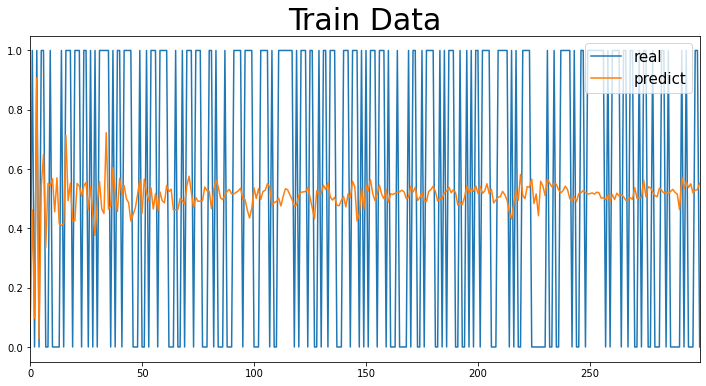

In [101]:
import matplotlib.pyplot as plt

draw=pd.concat([pd.DataFrame(Y_train),pd.DataFrame(Y_train_predict)],axis=1)
draw.iloc[:300,0].plot(figsize=(12,6))
draw.iloc[:300,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现

* 测试集

In [102]:
#在测试集上的预测
Y_test_predict=model.predict(X_test)[:,0]
Y_test=Y_test

Text(0.5, 1.0, 'Test Data')

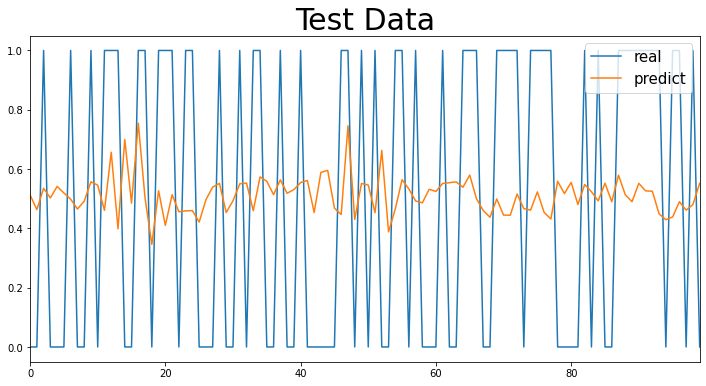

In [103]:
draw=pd.concat([pd.DataFrame(Y_test),pd.DataFrame(Y_test_predict)],axis=1);
draw.iloc[:100,0].plot(figsize=(12,6))
draw.iloc[:100,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题
# 展示在测试集上的表现

In [104]:
txt = np.zeros(len(Y_test))
test_predict = Y_test_predict.copy()
test_predict[Y_test_predict > 0.5] = 1
test_predict[Y_test_predict <= 0.5] = 0

train_predict = Y_train_predict.copy()
train_predict[Y_train_predict > 0.5] = 1
train_predict[Y_train_predict <= 0.5] = 0

result = metrics.accuracy_score(Y_test, test_predict)
'测试集正确率:',result

('测试集正确率:', 0.520362547233409)

* 训练过程Loss,Accuracy的变化

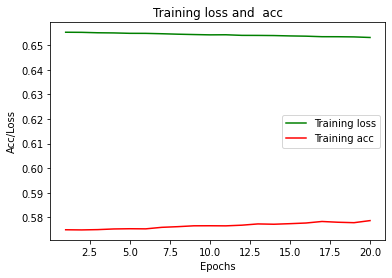

In [105]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, acc, 'r', label='Training acc')  
plt.title('Training loss and  acc')
plt.xlabel('Epochs')
plt.ylabel('Acc/Loss')
plt.legend()

* ROC曲线以及AUC值

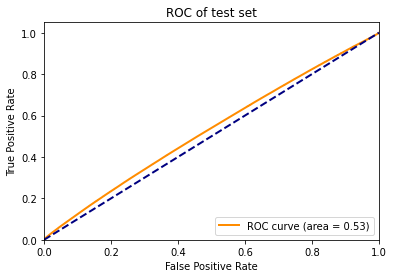

In [106]:
# 测试集
Y_test
Y_test_predict
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_predict, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of test set')
plt.legend(loc="lower right")
plt.show()

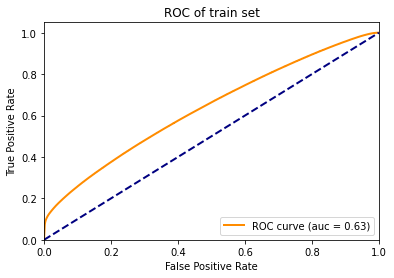

In [107]:
# 训练集
fpr, tpr, thresholds = metrics.roc_curve(Y_train, Y_train_predict, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (auc = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of train set')
plt.legend(loc="lower right")
plt.show()

* f1-score

In [108]:
print(metrics.f1_score(Y_train, train_predict))
print(metrics.f1_score(Y_test, test_predict))

0.6272143559103738
0.5502931072919622


* 混淆矩阵

In [109]:
metrics.confusion_matrix(Y_train, train_predict)

array([[ 759668,  721148],
       [ 583371, 1097431]])

In [110]:
metrics.confusion_matrix(Y_test, test_predict)

array([[335911, 395115],
       [314947, 434441]])

* 显示主要分类指标

In [111]:
print(metrics.classification_report(Y_train,train_predict))

              precision    recall  f1-score   support

         0.0       0.57      0.51      0.54   1480816
         1.0       0.60      0.65      0.63   1680802

    accuracy                           0.59   3161618
   macro avg       0.58      0.58      0.58   3161618
weighted avg       0.59      0.59      0.59   3161618



In [112]:
print(metrics.classification_report(Y_test,test_predict))

              precision    recall  f1-score   support

         0.0       0.52      0.46      0.49    731026
         1.0       0.52      0.58      0.55    749388

    accuracy                           0.52   1480414
   macro avg       0.52      0.52      0.52   1480414
weighted avg       0.52      0.52      0.52   1480414



## 5. 保存模型

In [113]:
model.save('./models/lstm_model4_3.h5')

## 6. 保存预测结果

In [114]:
testResult.shape

(1480414, 6, 16)

In [115]:
testResult[:,-1,:2]

array([['2020-01-09', '000001.SZ'],
       ['2020-01-10', '000001.SZ'],
       ['2020-01-13', '000001.SZ'],
       ...,
       ['2021-07-28', '688981.SH'],
       ['2021-07-29', '688981.SH'],
       ['2021-07-30', '688981.SH']], dtype=object)

In [116]:
len(Y_test_predict)

1480414

In [117]:
pred_df = pd.DataFrame(testResult[:, -1, :2], columns = ['dt', 'kdcode'])

In [118]:
pred_df

,dt,kdcode
0,2020-01-09,000001.SZ
1,2020-01-10,000001.SZ
2,2020-01-13,000001.SZ
3,2020-01-14,000001.SZ
4,2020-01-15,000001.SZ
...,...,...
1480409,2021-07-26,688981.SH
1480410,2021-07-27,688981.SH
1480411,2021-07-28,688981.SH
1480412,2021-07-29,688981.SH


In [119]:
pred_df['score'] = Y_test_predict

In [120]:
pred_df

,dt,kdcode,score
0,2020-01-09,000001.SZ,0.512615
1,2020-01-10,000001.SZ,0.463373
2,2020-01-13,000001.SZ,0.534937
3,2020-01-14,000001.SZ,0.502544
4,2020-01-15,000001.SZ,0.541570
...,...,...,...
1480409,2021-07-26,688981.SH,0.560508
1480410,2021-07-27,688981.SH,0.500277
1480411,2021-07-28,688981.SH,0.398535
1480412,2021-07-29,688981.SH,0.429811


In [121]:
pred_df = pred_df[['kdcode', 'dt', 'score']]
pred_df

,kdcode,dt,score
0,000001.SZ,2020-01-09,0.512615
1,000001.SZ,2020-01-10,0.463373
2,000001.SZ,2020-01-13,0.534937
3,000001.SZ,2020-01-14,0.502544
4,000001.SZ,2020-01-15,0.541570
...,...,...,...
1480409,688981.SH,2021-07-26,0.560508
1480410,688981.SH,2021-07-27,0.500277
1480411,688981.SH,2021-07-28,0.398535
1480412,688981.SH,2021-07-29,0.429811


In [122]:
all_date = pred_df["dt"].unique()
all_date = all_date[:-8]
len(all_date)

370

In [123]:
for date_i in tqdm(all_date):
    tmp_df = pred_df[pred_df['dt'] == date_i]
    save_path = '../result4tiho/model4_3/prediction/' + str(date_i) + '.csv'
    tmp_df.set_index(tmp_df['kdcode'])
    tmp_df.to_csv(save_path, index = False)

100%|██████████| 370/370 [00:26<00:00, 14.19it/s]
